# Gather Dependencie


In [1]:
# Dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# from sodapy import Socrata
from config import census_key
import pprint
import requests
import csv
import os
import gmaps
import seaborn as sns


# Function for Quickly Calling a DataFrame

In [2]:
# Function for quickly assempling a DataFrame
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

# Create DataFrame for CDC Data

In [3]:
cdc_data = pd.read_csv("../Project_1/cdc_data.csv")
cdc_data
cdc_df = pd.DataFrame(cdc_data)
cdc_df

# Choose the columns we want and rename anything that isn't clear
cdc_df = cdc_df[['case_month', 'res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 'current_status']]
cdc_df = cdc_df.rename(columns={
    'res_state': 'State',
    'res_county': 'County',
    'ethnicity': 'Ethnicity',
    'current_status': 'Infection Status',
    'race':'Race'
})

# Drop "Unkown" race from dataset
cdc_df = cdc_df.loc[cdc_df['Race']!= 'Unknown', :]

# Set Infections to 1 and replace the various races with values that are compatible with the census data
cdc_df['Infections'] = 1
cdc_df['Race'] = cdc_df['Race'].replace('White', 'Caucasian')
cdc_df['Race'] = cdc_df['Race'].replace('Black', 'African American')
cdc_df['Race'] = cdc_df['Race'].replace('American Indian/Alaska Native', 'Native American')
cdc_df['Race'] = cdc_df['Race'].replace('Multiple/Other', 'Other')
cdc_df['Race'] = np.where(np.logical_and(cdc_df['Race'] == 'Caucasian', cdc_df['Ethnicity'] == 'Hispanic/Latino'), 'Hispanic', cdc_df['Race'])

# NOTE: It's not clear what happens with Hawaiian here. 

cdc_df.head(50)



,case_month,State,County,age_group,sex,Race,Ethnicity,Infection Status,Infections
0,2021-11,MN,STEELE,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
2,2021-11,MN,STEARNS,50 to 64 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
3,2020-05,MN,KANDIYOHI,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
4,2021-05,MN,ANOKA,18 to 49 years,Male,NaN,NaN,Laboratory-confirmed case,1
5,2020-04,MN,CLAY,65+ years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
6,2020-10,MN,NOBLES,18 to 49 years,Female,Hispanic,Hispanic/Latino,Laboratory-confirmed case,1
7,2020-10,MN,NaN,0 - 17 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
8,2021-12,MN,ANOKA,18 to 49 years,Female,NaN,NaN,Laboratory-confirmed case,1
9,2022-05,MN,SHERBURNE,18 to 49 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
10,2020-11,MN,KANDIYOHI,18 to 49 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1


# Drop NaN and Compile Totals by County and Race

In [4]:
# Drop NaNs and then group by County and Race
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
cdc_df = cdc_grouped_county.count()
cdc_df.reset_index(inplace=True)
cdc_df

,County,Race,Infections
0,ANOKA,African American,2864
1,ANOKA,Asian,1732
2,ANOKA,Caucasian,24501
3,ANOKA,Hispanic,746
4,ANOKA,Native American,73
...,...,...,...
172,WRIGHT,African American,107
173,WRIGHT,Asian,49
174,WRIGHT,Caucasian,10656
175,WRIGHT,Hispanic,109


# Create Poverty DataFrame Based on US Census

In [5]:
# Poverty DataFrame By Race - 2020

url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B17001_002E,B17001A_002E,B17001B_002E,B17001C_002E,B17001D_002E,B17001E_002E,B17001F_002E,B17001G_002E,B17001H_002E,B17001I_002E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)
response
poverty_df = json_to_dataframe(response)

# Split NAME into County & State
name = poverty_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = poverty_df['County'] = name[0]
STATE = poverty_df['State'] = name[1]
poverty_df.drop(columns=["NAME"], inplace=True)
poverty_df['Caucasian2'] = poverty_df['B17001A_002E'].astype(int) - poverty_df['B17001I_002E'].astype(int)
poverty_df['Other'] = poverty_df['B17001F_002E'].astype(int) + poverty_df['B17001G_002E'].astype(int)


# Get the columns we want
poverty_df = poverty_df[['County', 'State','B17001_002E','Caucasian2', 'B17001B_002E','B17001C_002E','B17001D_002E','B17001E_002E','Other','B17001I_002E']]

# Rename columns to something intelligible
poverty_df = poverty_df.rename(columns={
    'B17001_002E':'Poverty Total',
    'Caucasian2':'Caucasian',
    'B17001B_002E':'African American',
    'B17001C_002E':'Native American',
    'B17001D_002E':'Asian',
    'B17001E_002E':'Hawaiian', # I had to change this from Native Hawaiian to Hawaiian for compatibility with the rest - Dom
    'B17001I_002E':'Hispanic' 
    })

# # Remove ...County from County in dataframe
poverty_df['County'] = poverty_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
poverty_df['County'] = poverty_df['County'].str.strip()

# And then convert the county name to uppercase
poverty_df['County'] = poverty_df['County'].str.upper()

poverty_df['Year'] = 2020
#poverty_df.to_csv("../Project_1/population_in_poverty.csv")
poverty_df



,County,State,Poverty Total,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic,Year
0,ANOKA,Minnesota,20270,11778,3697,327,953,0,1964,1551,2020
1,BECKER,Minnesota,3588,2296,17,709,45,0,381,140,2020
2,BELTRAMI,Minnesota,8167,3657,310,3056,39,0,734,371,2020
3,BENTON,Minnesota,3357,2605,333,19,73,0,205,122,2020
4,BIG STONE,Minnesota,596,596,0,0,0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...
82,RENVILLE,Minnesota,1373,717,29,97,8,0,245,277,2020
83,ROSEAU,Minnesota,1133,971,6,67,11,0,28,50,2020
84,SHERBURNE,Minnesota,4953,2857,578,171,251,0,737,359,2020
85,STEELE,Minnesota,2887,1835,426,113,3,0,149,361,2020


In [6]:
# Choose only the columns we need
poverty_df = poverty_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
poverty_df

,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,11778,3697,327,953,0,1964,1551
1,BECKER,2296,17,709,45,0,381,140
2,BELTRAMI,3657,310,3056,39,0,734,371
3,BENTON,2605,333,19,73,0,205,122
4,BIG STONE,596,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
82,RENVILLE,717,29,97,8,0,245,277
83,ROSEAU,971,6,67,11,0,28,50
84,SHERBURNE,2857,578,171,251,0,737,359
85,STEELE,1835,426,113,3,0,149,361


In [7]:
# Use melt to convert this into a format similar to the CDC data
poverty_df = poverty_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                    'Hawaiian', 'Other', 'Hispanic'], \
                                                     var_name='Race', value_name='Poverty')
poverty_gb = poverty_df.groupby(['County', 'Race'])
poverty_df = poverty_gb.sum()
poverty_df.reset_index(inplace=True)
poverty_df

,County,Race,Poverty
0,AITKIN,African American,13
1,AITKIN,Asian,0
2,AITKIN,Caucasian,1711
3,AITKIN,Hawaiian,0
4,AITKIN,Hispanic,45
...,...,...,...
604,YELLOW MEDICINE,Caucasian,722
605,YELLOW MEDICINE,Hawaiian,0
606,YELLOW MEDICINE,Hispanic,53
607,YELLOW MEDICINE,Native American,30


# Create Population DataFrame by County and Race

In [8]:
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Population Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
mn_pop_df['County'] = mn_pop_df['County'].str.strip()

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Population Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df

,County,Population Total,Caucasian,African American,Native American,Asian,Hawaiian,Hispanic,Other
0,ANOKA,353775,283436,23534,1788,16082,86,16769,12080
1,BECKER,34227,29290,146,1938,209,6,738,1900
2,BELTRAMI,46784,33506,399,8920,295,36,1114,2514
3,BENTON,40476,35979,1876,49,378,0,1086,1108
4,BIG STONE,4974,4787,3,3,0,0,102,79
...,...,...,...,...,...,...,...,...,...
82,RENVILLE,14572,12741,67,186,108,0,1268,202
83,ROSEAU,15259,13876,124,254,399,0,223,383
84,SHERBURNE,96015,86342,2658,403,1206,0,2577,2829
85,STEELE,36710,31640,1225,119,150,6,2913,657


# Coordinates for Heat Map --If time permits

In [9]:
# Get the coordinates of counties in MN
url = "https://en.wikipedia.org/wiki/User:Michael_J/County_table"

table = pd.read_html(url)
df = table[0]
Counties = df.loc[df['State'] == "MN", : ]
counties_df = Counties[['County [2]', 'Latitude', 'Longitude']]
counties_df#.to_csv("../Project_1/county_geo.csv")  

,County [2],Latitude,Longitude
1314,Aitkin,+46.602446°,–93.419760°
1315,Anoka,+45.274110°,–93.242723°
1316,Becker,+46.937629°,–95.741757°
1317,Beltrami,+47.878825°,–94.986698°
1318,Benton,+45.701227°,–94.001440°
...,...,...,...
1396,Watonwan,+43.978366°,–94.614128°
1397,Wilkin,+46.362335°,–96.476657°
1398,Winona,+43.982268°,–91.776708°
1399,Wright,+45.175091°,–93.966397°


In [10]:
# Choose only the columns we need
mn_pop_df = mn_pop_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
mn_pop_df

,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,283436,23534,1788,16082,86,12080,16769
1,BECKER,29290,146,1938,209,6,1900,738
2,BELTRAMI,33506,399,8920,295,36,2514,1114
3,BENTON,35979,1876,49,378,0,1108,1086
4,BIG STONE,4787,3,3,0,0,79,102
...,...,...,...,...,...,...,...,...
82,RENVILLE,12741,67,186,108,0,202,1268
83,ROSEAU,13876,124,254,399,0,383,223
84,SHERBURNE,86342,2658,403,1206,0,2829,2577
85,STEELE,31640,1225,119,150,6,657,2913


In [11]:
# Use melt to convert this into a format similar to the CDC data
pop_df = mn_pop_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                      'Hawaiian', 'Other', 'Hispanic'], \
                                                      var_name='Race', value_name='Population')
pop_gb = pop_df.groupby(['County', 'Race'])
pop_df = pop_gb.sum()
pop_df.reset_index(inplace=True)
pop_df

,County,Race,Population
0,AITKIN,African American,61
1,AITKIN,Asian,40
2,AITKIN,Caucasian,14831
3,AITKIN,Hawaiian,9
4,AITKIN,Hispanic,216
...,...,...,...
604,YELLOW MEDICINE,Caucasian,8725
605,YELLOW MEDICINE,Hawaiian,0
606,YELLOW MEDICINE,Hispanic,468
607,YELLOW MEDICINE,Native American,229


# Merge the Datasets

In [12]:
# Edited merge_df for nan infections to be 0
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'], how = "left")
merged_df["Infections"] = merged_df["Infections"].fillna(0)
merged_df

,County,Race,Population,Poverty,Infections
0,AITKIN,African American,61,13,0.0
1,AITKIN,Asian,40,0,0.0
2,AITKIN,Caucasian,14831,1711,0.0
3,AITKIN,Hawaiian,9,0,0.0
4,AITKIN,Hispanic,216,45,0.0
...,...,...,...,...,...
604,YELLOW MEDICINE,Caucasian,8725,722,0.0
605,YELLOW MEDICINE,Hawaiian,0,0,0.0
606,YELLOW MEDICINE,Hispanic,468,53,0.0
607,YELLOW MEDICINE,Native American,229,30,0.0


In [13]:
# Convert all numerical values in merged_df from strings to int
merged_df["Population"] = merged_df["Population"].astype(int)
merged_df["Poverty"] = merged_df["Poverty"].astype(int)
merged_df["Infections"] = merged_df["Infections"].astype(int)

# Calculate poverty and infection rates
poverty_rate = []
infection_rate = []

i = 0
while i < len(merged_df):
    if merged_df["Population"][i] == 0:
        poverty_rate.append(0)
        infection_rate.append(0)
    else: 
        poverty_rate.append(merged_df["Poverty"][i] / merged_df["Population"][i])
        infection_rate.append(merged_df["Infections"][i] / merged_df["Population"][i])
    i += 1
    
merged_df["Poverty Rate"] = poverty_rate
merged_df["Infection Rate"] = infection_rate

merged_df[merged_df["County"] == "CROW WING"]    

,County,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate
119,CROW WING,African American,538,192,0,0.356877,0.000000
120,CROW WING,Asian,276,3,0,0.010870,0.000000
121,CROW WING,Caucasian,61215,5803,5113,0.094797,0.083525
122,CROW WING,Hawaiian,0,0,0,0.000000,0.000000
123,CROW WING,Hispanic,969,56,0,0.057792,0.000000
124,CROW WING,Native American,534,113,0,0.211610,0.000000
125,CROW WING,Other,1243,192,0,0.154465,0.000000


# Summary Statistics --Mean, Median, Variance, St. Dev., and SEM (Moe's)

In [14]:
#Mean and Median
mean_df = merged_df.groupby('Race').mean()
mean_df.reset_index()

,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,African American,4075.172414,1053.126437,419.160920,0.263118,0.023234
1,Asian,3139.080460,399.045977,238.988506,0.137476,0.010979
2,Caucasian,50833.218391,3045.620690,3776.333333,0.075060,0.044010
3,Hawaiian,21.896552,4.114943,0.000000,0.052836,0.000000
4,Hispanic,3536.494253,602.609195,117.988506,0.204458,0.010016
5,Native American,556.425287,189.965517,35.000000,0.310673,0.012460
6,Other,2207.436782,581.206897,63.206897,0.394056,0.006409


In [15]:
# def median(ethnicity):
#     mean_df[mean_df['Infections']== ethnicity]['Race'].quantile(0.5)
#     print(ethnicity)
#     return median

# Race = median('African American')
# Race

In [17]:
# Statistics by county
#lief's groupby
merged_county_gb = merged_df.groupby(["County"])

county_pop_stats = merged_county_gb["Population"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_pov_stats = merged_county_gb["Poverty"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_inf_stats = merged_county_gb["Infections"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_pov_rate_stats = merged_county_gb["Poverty Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_inf_rate_stats = merged_county_gb["Infection Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])

In [18]:
#  county_pop_stats.T

In [19]:
# merge the county_pov_stats df with county_pove_rate_stats
merged_county_pov_stats_df = pd.merge(county_pov_stats, county_pov_rate_stats, on='County',  how='inner')

#rename columns
col_names = {'max_x':'Cty_Pov_Stats_Max',
            'min_x' :'Cty_Pov_Stats_Min',
            'mean_x' :'Cty_Pov_Stats_Mean',
            'median_x':'Cty_Pov_Stats_Median',
            'var_x':'Cty_Pov_Stats_Variance',
            'std_x':'Cty_Pov_Stats_Std',
            'sem_x':'Cty_Pov_Stats_SEM',
            'max_y':'Cty_Pov_Rate_Max',
            'min_y':'Cty_Pov_Rate_Min',
            'mean_y':'Cty_Pov_Rate_Mean',
            'median_y':'Cty_Pov_Rate_Median',
            'var_y':'Cty_Pov_Rate_Variance',
            'std_y':'Cty_Pov_Rate_Std',
            'sem_y':'Cty_Pov_Rate_SEM'}

merged_county_pov_stats_df = merged_county_pov_stats_df.rename(columns=col_names)
#merged_county_pov_stats_df

In [20]:
#merge county_inf_stats df with county_inf_rate_stats 

merged_county_inf_stats_df = pd.merge(county_inf_stats, county_inf_rate_stats, on='County', how='inner')

#rename columns

col_names2 = {
            'max_x':'Cty_Infect_Stats_Max',
            'min_x':'Cty_Infect_Stats_Min',
            'mean_x':'Cty_Infect_Stats_Mean',
            'median_x':'Cty_Infect_Stats_Median',
            'var_x':'Cty_Infect_Stats_Variance',
            'std_x':'Cty_Infect_Stats_Std',
            'sem_x':'Cty_Infect_Stats_SEM',
            'max_y':'Cty_Infect_Rate_Max',
            'min_y':'Cty_Infect_Rate_Min',
            'mean_y':'Cty_Infect_Rate_Mean',
            'median_y':'Cty_Infect_Rate_Median',
            'var_y':'Cty_Infect_Rate_Variance',
            'std_y':'Cty_Infect_Rate_Std',
            'sem_y':'Cty_Infect_Rate_SEM'}

merged_county_inf_stats_df = merged_county_inf_stats_df.rename(columns=col_names2)
#merged_county_inf_stats_df

# Mai's Code starts Here

# Bar Charts on Race and Poverty 

<AxesSubplot:title={'center':'The Number of People in Poverty in Minnesota'}, xlabel='Race', ylabel='Poverty'>

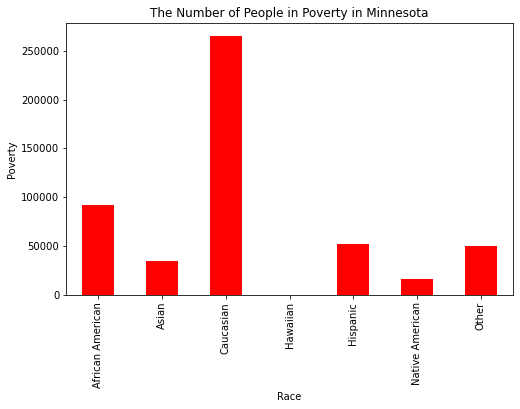

In [21]:
# Generate a bar plot showing the total population of race groups, poverty and analyzing the differences of each groups for the merged dataframe
bar_plot_data = merged_df.groupby(['Race']).sum()["Poverty"]
plt.title("The Number of People in Poverty in Minnesota")
plt.xlabel("Race")
plt.ylabel("Poverty")
bar_plot_data.plot.bar(figsize=(8,5),color=('red'))


In [23]:
plot_df = merged_df.groupby(['Race']).sum()
plot_df


,Population,Poverty,Infections,Poverty Rate,Infection Rate
Race,,,,,
African American,354540,91622,36467,22.891273,2.021357
Asian,273100,34717,20792,11.960411,0.955200
Caucasian,4422490,264969,328541,6.530205,3.828903
Hawaiian,1905,358,0,4.596706,0.000000
Hispanic,307675,52427,10265,17.787846,0.871395
Native American,48409,16527,3045,27.028563,1.083980
Other,192047,50565,5499,34.282836,0.557564


In [24]:
max_pop = plot_df['Population'].max()
max_pop

4422490

Text(0, 0.5, 'Population (in millions)')

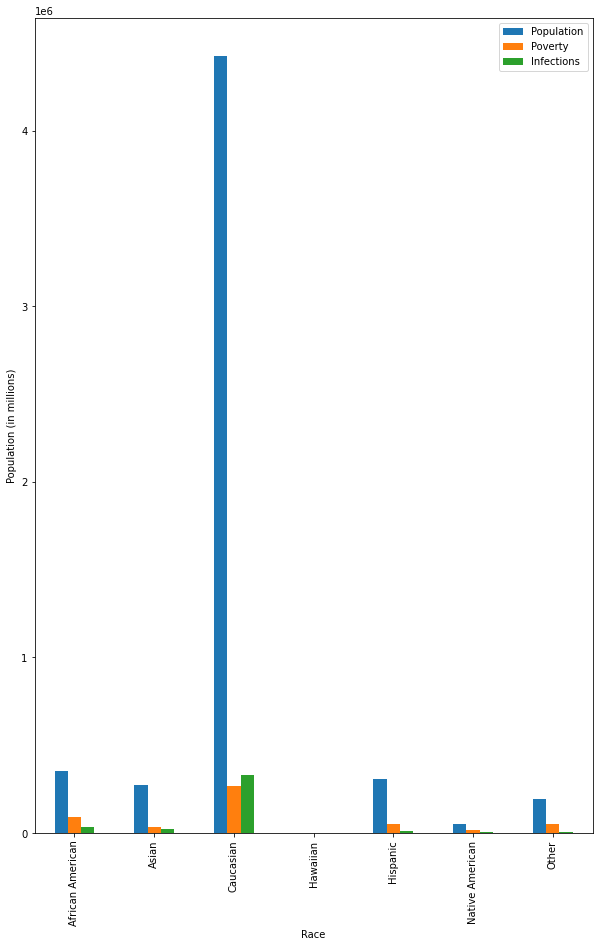

In [25]:
# Generate a bar chart to show the max population, poverty and infections of each race in MN
plot_df[['Population','Poverty','Infections']].plot.bar(figsize=(10,15))
plt.xlabel("Race")
plt.ylabel("Population (in millions)")


Text(0, 0.5, 'Rate')

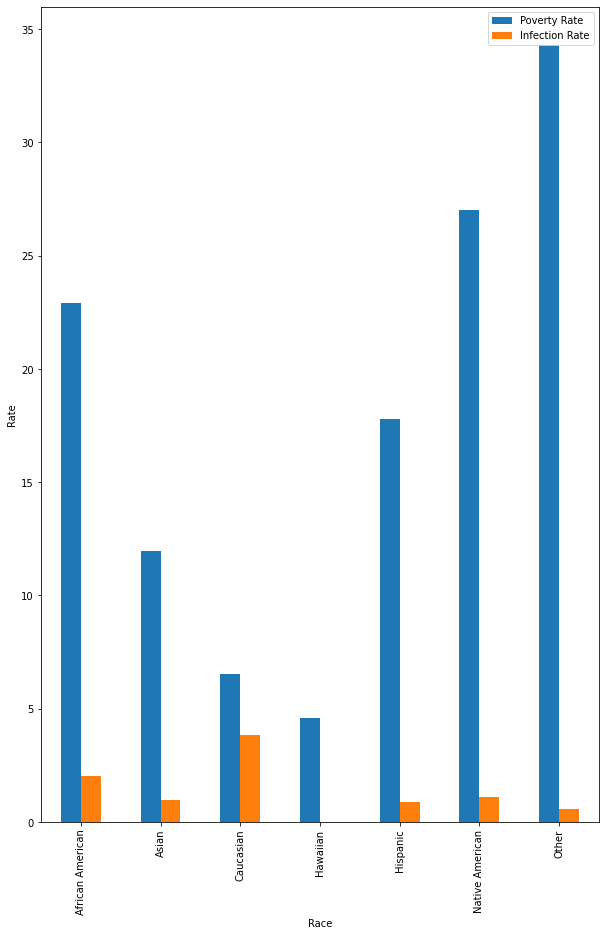

In [26]:
# Generate a 3 bar chart to show poverty rate and infection rate for each of the race in MN
plot_df[['Poverty Rate','Infection Rate']].plot.bar(figsize=(10,15))
plt.xlabel("Race")
plt.ylabel("Rate")

# Mai's Boxplots

# Boxplots Based on Race and Poverty

<AxesSubplot:title={'center':'Poverty Rate'}, xlabel='Race'>

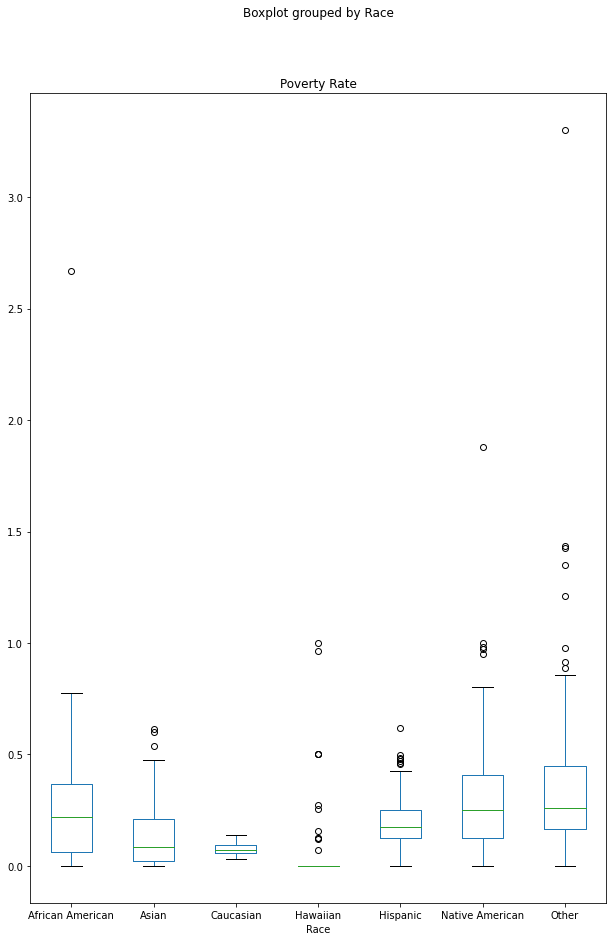

In [27]:
# Generate a bar plot showing the total population and race groups
merged_df.boxplot(by='Race', column=['Poverty Rate'], grid=False,figsize=(10, 15))


In [ ]:
# Generate a bar plot showing the total population and race groups
merged_df.boxplot(by='Race', column=['Infections'], grid=False,figsize=(10, 15))

In [ ]:
merged_df.plot.scatter(x='Poverty',y='Race',s=10)
#plt.figure(figsize=(100,50)

In [ ]:
# Line
merged_df.plot.scatter(x='Infections',y='Race',)